In [1]:
import pandas as pd
import gzip
import json
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import numpy as np


In [2]:
import os

os.getcwd()

os.chdir('/home/jovyan/git/WebRec/Project')

ReviewData

In [3]:
f = gzip.open("All_Beauty.jsonl.gz")
review = []
for l in f:
    review.append(json.loads(l))

In [4]:
len(review)

701528

In [5]:
review = pd.DataFrame(review)
#review.head()

In [6]:
print(review.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             701528 non-null  float64
 1   title              701528 non-null  object 
 2   text               701528 non-null  object 
 3   images             701528 non-null  object 
 4   asin               701528 non-null  object 
 5   parent_asin        701528 non-null  object 
 6   user_id            701528 non-null  object 
 7   timestamp          701528 non-null  int64  
 8   helpful_vote       701528 non-null  int64  
 9   verified_purchase  701528 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 48.8+ MB
None


We are taking only the verified purchase data

In [7]:
review = review[review['verified_purchase'] == True]
review

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True
...,...,...,...,...,...,...,...,...,...,...
701521,5.0,Perfect hair choice!!!!,Absolutely love!! It hold curls well. It dyed ...,[{'small_image_url': 'https://images-na.ssl-im...,B00H1L4RAU,B00H1L4RAU,AHMU2NL2V6PT7KCAR6FNCM2GAYSA,1433552959000,9,True
701522,1.0,I got a completely different bottle than this.,What I got was a completely different bottle t...,[],B00K21WP3M,B00K21WP3M,AGZIX3V6YHAG3JCUUUWY57FBO5OA,1586455368241,0,True
701523,4.0,Four Stars,Conditioner is great shampoo not as I expected,[],B006YUIWKA,B006YUIWKA,AFIXGFVEGLMOTMBTJL7H3VSIETDQ,1478227021000,0,True
701525,5.0,Great sunless tanner,Product as expected. Shipping was on time.,[],B06ZZV9MZT,B06ZZV9MZT,AHYDCWDMMVMLBX7FY7M7JKADKRDQ,1590547974067,0,True


In [8]:
print(review['helpful_vote'].describe())

count    634969.000000
mean          0.905071
std           5.352673
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         646.000000
Name: helpful_vote, dtype: float64


In [9]:
review['timestamp'] = pd.to_datetime(review['timestamp'] / 1000, unit='s')

We don't have primary key so I am combining columns to find if there is any duplicate data.

In [10]:
duplicate_rows = review[review.duplicated(subset=['user_id', 'asin', 'text','parent_asin'], keep=False)]
print(duplicate_rows)


        rating                                              title  \
6565       5.0                                         Five Stars   
6566       5.0                                         Five Stars   
6713       5.0                              Moisturizing  ur skin   
6714       5.0                              Useful For Showering.   
6715       5.0                              Moisturizing  ur skin   
...        ...                                                ...   
701456     2.0                       Cute but not water resistant   
701474     5.0  Easy replacement after i dumped a water bottle...   
701477     5.0  Easy replacement after i dumped a water bottle...   
701518     1.0                                           One Star   
701519     1.0                                           One Star   

                                                     text images        asin  \
6565                                 Great for the price.     []  B00NT0AR7E   
6566       

Checking manually(random asin number in duplicated rows) to see if the data has duplicated elements or not. I took 'user_id', 'asin', 'text','parent_asin' and combined them to use as a surrogate key to check for duplicates.

In [11]:
check_rows = duplicate_rows[duplicate_rows['asin'].isin(['B00NT0AR7E', 'B00WDKPW9O','B07VQZPHHF'])]
check_rows.to_excel('check_rows.xlsx', index=False)

Found that there are duplicates in the data, so dropping the duplicates

In [12]:
review_cleaned = review.drop_duplicates(subset=['user_id', 'asin', 'text', 'parent_asin'], keep='first')

Now again checking the data to see if there are any duplicates left or not.

In [13]:
review_cleaned['concat_column'] = review_cleaned['text'] + '_' + review_cleaned['asin'] + '_' + review_cleaned['parent_asin'] + '_' + review_cleaned['user_id']

/tmp/ipykernel_36811/973234546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_cleaned['concat_column'] = review_cleaned['text'] + '_' + review_cleaned['asin'] + '_' + review_cleaned['parent_asin'] + '_' + review_cleaned['user_id']


In [14]:
check_rows_1 = review_cleaned[review_cleaned['asin'].isin(['B00NT0AR7E', 'B00WDKPW9O','B07VQZPHHF'])]
check_rows_1.to_excel('check_rows1.xlsx', index=False)

In [15]:
unique_count = check_rows_1['concat_column'].nunique()
unique_count

274

In [16]:
review_cleaned.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,concat_column
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,0,True,This spray is really nice. It smells really go...
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.069999933,1,True,"This product does what I need it to do, I just..."
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052000046,2,True,"Smells good, feels great!_B07PNNCSP9_B097R46CS..."
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220000029,0,True,Felt synthetic_B09JS339BZ_B09JS339BZ_AFQLNQNQY...
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.533999919,0,True,Love it_B08BZ63GMJ_B08BZ63GMJ_AFQLNQNQYFWQZPJQ...


In [17]:
review_cleaned['text'] = review_cleaned['text'].str.lower()
review_cleaned = review_cleaned.drop(columns=['images'])

/tmp/ipykernel_36811/4016310951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_cleaned['text'] = review_cleaned['text'].str.lower()


In [18]:
review_cleaned['year'] = review_cleaned['timestamp'].dt.year
review_cleaned['month'] = review_cleaned['timestamp'].dt.month
print(len(review_cleaned))

628456


MetaData

In [19]:
f = gzip.open("meta_All_Beauty.jsonl.gz")
metadata = []
for l in f:
    metadata.append(json.loads(l))

In [20]:
len(metadata)

112590

In [21]:
metadata = pd.DataFrame(metadata)

In [22]:
metadata.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Howard Products,[],{'Package Dimensions': '7.1 x 5.5 x 3 inches; ...,B01CUPMQZE,None
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Yes To,[],"{'Item Form': 'Powder', 'Skin Type': 'Acne Pro...",B076WQZGPM,None
2,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Levine Health Products,[],{'Manufacturer': 'Levine Health Products'},B000B658RI,None
3,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Cherioll,[],"{'Brand': 'Cherioll', 'Item Form': 'Powder', '...",B088FKY3VD,None
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7,"[Material: 304 Stainless Steel; Brass tip, Len...",[The Precision Plunger Bars are designed to wo...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Precision,[],{'UPC': '644287689178'},B07NGFDN6G,None


In [23]:
metadata = metadata.drop(columns=['features','images','videos'])

Parent_asin is the primary key in the metadata data.

In [24]:
unique_count1 = metadata['parent_asin'].nunique()
unique_count1

112590

In [25]:
print(metadata.isnull().sum())

main_category           0
title                   0
average_rating          0
rating_number           0
description             0
price               94886
store               11331
categories              0
details                 0
parent_asin             0
bought_together    112590
dtype: int64


In [26]:
metadata['rating_number'].dtype

dtype('int64')

Merging the review and meta data on 'parent_asin' column.

In [27]:
merged_data = review_cleaned.merge(metadata, on='parent_asin', how='inner')
len(merged_data)

628456

In [28]:
missing_matches = review[~review['parent_asin'].isin(metadata['parent_asin'])]
missing_matches

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase


No data is missing while merging the data.

In [29]:
merged_data.head()

,rating,title_x,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,concat_column,...,main_category,title_y,average_rating,rating_number,description,price,store,categories,details,bought_together
0,5.0,Such a lovely scent but not overpowering.,this spray is really nice. it smells really go...,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,0,True,This spray is really nice. It smells really go...,...,All Beauty,Herbivore - Natural Sea Mist Texturizing Salt ...,4.3,384,"[If given the choice, weÕd leave most telltale...",NaN,HERBIVORE,[],"{'Hair Type': 'Wavy', 'Material Type Free': 'D...",None
1,4.0,Works great but smells a little weird.,"this product does what i need it to do, i just...",B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.069999933,1,True,"This product does what I need it to do, I just...",...,All Beauty,All Natural Vegan Dry Shampoo Powder - Eco Fri...,4.0,56,[],NaN,Two Goats Apothecary,[],"{'Brand': 'Two Goats Apothecary', 'Item Form':...",None
2,5.0,Yes!,"smells good, feels great!",B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052000046,2,True,"Smells good, feels great!_B07PNNCSP9_B097R46CS...",...,All Beauty,New Road Beauty - Creamsicle - Variety 3 Pack ...,4.4,699,[New Road Beauty Paraffin Wax is recommended f...,21.98,New Road Beauty,[],{'Package Dimensions': '10.5 x 6.4 x 1.6 inche...,None
3,1.0,Synthetic feeling,felt synthetic,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220000029,0,True,Felt synthetic_B09JS339BZ_B09JS339BZ_AFQLNQNQY...,...,All Beauty,muaowig Ombre Body Wave Bundles 1B Grey Human ...,1.0,1,[Hair Material: Brazilian Virgin Human Hair Bu...,NaN,muaowig,[],"{'Brand': 'muaowig', 'Material': 'Human Hair',...",None
4,5.0,A+,love it,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.533999919,0,True,Love it_B08BZ63GMJ_B08BZ63GMJ_AFQLNQNQYFWQZPJQ...,...,All Beauty,Yinhua Electric Nail Drill Kit Portable Profes...,3.5,20,[],NaN,Yinhua,[],{'Package Dimensions': '8.5 x 3.82 x 2.24 inch...,None


In [30]:
Amazon_data = merged_data
Amazon_data['year'].value_counts()


year
2020    116202
2021    113171
2019     92968
2018     67616
2017     61193
2022     54058
2016     53045
2015     30651
2014     12709
2023     12652
2013      7160
2012      2242
2011      1426
2010      1211
2009       699
2008       589
2007       550
2006       170
2005        89
2004        36
2003        15
2002         4
Name: count, dtype: int64

In [31]:
# filtering for year 2015 to 1013 in amazon_data inplace
Amazon_data = Amazon_data[Amazon_data['year'] >= 2015]
Amazon_data = Amazon_data[Amazon_data['year'] <= 2024]
Amazon_data['year'].value_counts()

year
2020    116202
2021    113171
2019     92968
2018     67616
2017     61193
2022     54058
2016     53045
2015     30651
2023     12652
Name: count, dtype: int64

1.Loaded the `All_Beauty.jsonl.gz` file and converted it into a dataframe.

2.Filtered the `review` DataFrame to include only rows where `verified_purchase` is `True`.

3.Converted the `timestamp` column from UNIX time (milliseconds) to a human-readable datetime format.

4.Checked & removed for duplicate rows based on the combination of `user_id`, `asin`, `text`, and `parent_asin` and stored them in `duplicate_rows`.

5.verified manually if the data is duplicated or not by exporting to excel.

6.Converted the `text` column to lowercase for uniformity.

7.Dropped the `images` column.

8.Extracted the year and month from the `timestamp` column and added them as new columns (`year` and `month`). not sure if needed but just in case.

9.Similarly loaded the meta data and verified if there are any missing values or duplicates. parents_asin is the primary key in the metadata data.

10.Dropped unwanted columns and checked for missing values and made sure it was merged properly with the review data.

11.After merging the data, I checked if there are any missing values in the merged data. There are no missing values in the merged data.

12.Finally we have 628,456 rows and 22 columns in the merged data - called "Amazon_data".


USE "Amazon_data" for further analysis.

QUICK ANALYSIS

In [32]:
Amazon_data.head(1)
Amazon_data['year'].value_counts()

year
2020    116202
2021    113171
2019     92968
2018     67616
2017     61193
2022     54058
2016     53045
2015     30651
2023     12652
Name: count, dtype: int64

In [33]:
Amazon_data.columns

Index(['rating', 'title_x', 'text', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'concat_column',
       'year', 'month', 'main_category', 'title_y', 'average_rating',
       'rating_number', 'description', 'price', 'store', 'categories',
       'details', 'bought_together'],
      dtype='object')

In [34]:
review_cleaned.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'concat_column',
       'year', 'month'],
      dtype='object')

In [35]:
metadata.columns

Index(['main_category', 'title', 'average_rating', 'rating_number',
       'description', 'price', 'store', 'categories', 'details', 'parent_asin',
       'bought_together'],
      dtype='object')

DATA PRE-PROCESSING (FURTHER ANALYSIS) AND TEXT PREPROCESSING

In [36]:
## STEP 1 - Rename some columns for clarity

Amazon_data.rename(columns={'title_x':'Review_Title','title_y':'Product_Title'},inplace=True)

Amazon_data.columns

Index(['rating', 'Review_Title', 'text', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'concat_column',
       'year', 'month', 'main_category', 'Product_Title', 'average_rating',
       'rating_number', 'description', 'price', 'store', 'categories',
       'details', 'bought_together'],
      dtype='object')

NULL VALUE IMPUTATION OR REMOVAL

In [37]:
## STEP 2 - 
# A. Removing the Concat column - since duplicates are already removed. Also, dropping verified purchase column since we are only looking into verified purchases

Amazon_data.drop(columns=['concat_column','verified_purchase'],inplace=True)

In [38]:
## B. 
## Checking the Price column - Since 72% of the data is null. This will not help in any useful analysis 

print('Percentage of null values in Price column is',Amazon_data['price'].isnull().sum()/Amazon_data.shape[0])
Amazon_data.drop(columns=['price'],inplace=True)

Percentage of null values in Price column is 0.7267901907719314


In [39]:
## C. Checking the bought together column - Since 100% of the data is null. This will not help in any useful analysis 

print('Percentage of null values in bought together column is',Amazon_data['bought_together'].isnull().sum()/Amazon_data.shape[0])
Amazon_data.drop(columns=['bought_together'],inplace=True)

Percentage of null values in bought together column is 1.0


In [40]:
## D. Since the null values in store column is only 6% , we will impute the store value to "Other" for these

print('Percentage of null values in store column is',Amazon_data['store'].isnull().sum()/Amazon_data.shape[0])

Amazon_data['store']=Amazon_data['store'].fillna('Other')
Amazon_data['store'].head()

Percentage of null values in store column is 0.067824109476092


0               HERBIVORE
1    Two Goats Apothecary
2         New Road Beauty
3                 muaowig
4                  Yinhua
Name: store, dtype: object

In [41]:
## E. Category column - has no valuable data, hence dropping it

print('The value count for categories column is',Amazon_data['categories'].value_counts())
Amazon_data.drop(columns=['categories'],inplace=True)

The value count for categories column is categories
[]    601556
Name: count, dtype: int64


In [42]:

## F. Since 98% of the data has "All Beauty", having that feature will not help in predicting the fake reviews
print('The value count for main categories column is',Amazon_data['main_category'].value_counts(normalize=True))
Amazon_data.drop(columns=['main_category'],inplace=True)


The value count for main categories column is main_category
All Beauty        0.989963
Premium Beauty    0.010037
Name: proportion, dtype: float64


In [43]:
Amazon_data.head(2)

,rating,Review_Title,text,asin,parent_asin,user_id,timestamp,helpful_vote,year,month,Product_Title,average_rating,rating_number,description,store,details
0,5.0,Such a lovely scent but not overpowering.,this spray is really nice. it smells really go...,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,0,2020,5,Herbivore - Natural Sea Mist Texturizing Salt ...,4.3,384,"[If given the choice, weÕd leave most telltale...",HERBIVORE,"{'Hair Type': 'Wavy', 'Material Type Free': 'D..."
1,4.0,Works great but smells a little weird.,"this product does what i need it to do, i just...",B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.069999933,1,2020,5,All Natural Vegan Dry Shampoo Powder - Eco Fri...,4.0,56,[],Two Goats Apothecary,"{'Brand': 'Two Goats Apothecary', 'Item Form':..."


TEXT PREPROCESSING

In [44]:

## In Text Pre-processing I will include Text, Review Title, and Description column - Since they would generally I have noisy data. I will be excluding the 'Product Title' 
## since data in these columns are generally clean and more structured 


In [45]:
## STEP 1 - Importing all necessary libraries:
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [46]:
## STEP 2 - Define a function to remove html tags, stop words, converting every string to a lower case, and tokenizing data, also reducing words to their base forms
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Rejoin tokens
    return " ".join(tokens)

In [47]:
## STEP 3 - Complete the pre-processing
# List of columns for text preprocessing
columns_to_preprocess = ['text', 'Review_Title', 'description']
# Apply the preprocessing function
for column in columns_to_preprocess:
    Amazon_data[f'{column}_cleaned'] = Amazon_data[column].astype(str).apply(preprocess_text)

/tmp/ipykernel_36811/645431852.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/tmp/ipykernel_36811/645431852.py:8: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/tmp/ipykernel_36811/645431852.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/tmp/ipykernel_36811/645431852.py:8: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed 

In [48]:
## Look at the final columns:
Amazon_data.columns

Amazon_data.head()

,rating,Review_Title,text,asin,parent_asin,user_id,timestamp,helpful_vote,year,month,Product_Title,average_rating,rating_number,description,store,details,text_cleaned,Review_Title_cleaned,description_cleaned
0,5.0,Such a lovely scent but not overpowering.,this spray is really nice. it smells really go...,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,0,2020,5,Herbivore - Natural Sea Mist Texturizing Salt ...,4.3,384,"[If given the choice, weÕd leave most telltale...",HERBIVORE,"{'Hair Type': 'Wavy', 'Material Type Free': 'D...",spray really nice smell really good go really ...,lovely scent overpowering,given choice wed leave telltale sign beachsunb...
1,4.0,Works great but smells a little weird.,"this product does what i need it to do, i just...",B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.069999933,1,2020,5,All Natural Vegan Dry Shampoo Powder - Eco Fri...,4.0,56,[],Two Goats Apothecary,"{'Brand': 'Two Goats Apothecary', 'Item Form':...",product need wish odorless soft coconut smell ...,work great smell little weird,
2,5.0,Yes!,"smells good, feels great!",B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052000046,2,2020,5,New Road Beauty - Creamsicle - Variety 3 Pack ...,4.4,699,[New Road Beauty Paraffin Wax is recommended f...,New Road Beauty,{'Package Dimensions': '10.5 x 6.4 x 1.6 inche...,smell good feel great,yes,new road beauty paraffin wax recommended beaut...
3,1.0,Synthetic feeling,felt synthetic,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220000029,0,2022,1,muaowig Ombre Body Wave Bundles 1B Grey Human ...,1.0,1,[Hair Material: Brazilian Virgin Human Hair Bu...,muaowig,"{'Brand': 'muaowig', 'Material': 'Human Hair',...",felt synthetic,synthetic feeling,hair material brazilian virgin human hair bund...
4,5.0,A+,love it,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.533999919,0,2020,12,Yinhua Electric Nail Drill Kit Portable Profes...,3.5,20,[],Yinhua,{'Package Dimensions': '8.5 x 3.82 x 2.24 inch...,love,,


In [49]:
#Amazon_data = Amazon_data[(Amazon_data['year']<=2023) & (Amazon_data['year']>=2015)]

In [50]:
Amazon_data.head()

,rating,Review_Title,text,asin,parent_asin,user_id,timestamp,helpful_vote,year,month,Product_Title,average_rating,rating_number,description,store,details,text_cleaned,Review_Title_cleaned,description_cleaned
0,5.0,Such a lovely scent but not overpowering.,this spray is really nice. it smells really go...,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,0,2020,5,Herbivore - Natural Sea Mist Texturizing Salt ...,4.3,384,"[If given the choice, weÕd leave most telltale...",HERBIVORE,"{'Hair Type': 'Wavy', 'Material Type Free': 'D...",spray really nice smell really good go really ...,lovely scent overpowering,given choice wed leave telltale sign beachsunb...
1,4.0,Works great but smells a little weird.,"this product does what i need it to do, i just...",B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.069999933,1,2020,5,All Natural Vegan Dry Shampoo Powder - Eco Fri...,4.0,56,[],Two Goats Apothecary,"{'Brand': 'Two Goats Apothecary', 'Item Form':...",product need wish odorless soft coconut smell ...,work great smell little weird,
2,5.0,Yes!,"smells good, feels great!",B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052000046,2,2020,5,New Road Beauty - Creamsicle - Variety 3 Pack ...,4.4,699,[New Road Beauty Paraffin Wax is recommended f...,New Road Beauty,{'Package Dimensions': '10.5 x 6.4 x 1.6 inche...,smell good feel great,yes,new road beauty paraffin wax recommended beaut...
3,1.0,Synthetic feeling,felt synthetic,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220000029,0,2022,1,muaowig Ombre Body Wave Bundles 1B Grey Human ...,1.0,1,[Hair Material: Brazilian Virgin Human Hair Bu...,muaowig,"{'Brand': 'muaowig', 'Material': 'Human Hair',...",felt synthetic,synthetic feeling,hair material brazilian virgin human hair bund...
4,5.0,A+,love it,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.533999919,0,2020,12,Yinhua Electric Nail Drill Kit Portable Profes...,3.5,20,[],Yinhua,{'Package Dimensions': '8.5 x 3.82 x 2.24 inch...,love,,


In [51]:
## STEP 4 - Drop the noisy text columns:
Amazon_data.drop(['Review_Title','text','Product_Title'],inplace=True,axis=1)

In [52]:
## STEP 5 - Preprocessing the "Details" column seperately since it has noisy data - 
import re
def preprocess_details(details):
    if not isinstance(details, dict):  # Handle missing or non-dictionary entries
        return {}
    
    processed_details = {}
    for key, value in details.items():
        # Clean keys and values: Remove special characters and convert to lowercase
        clean_key = re.sub(r"[^a-zA-Z\s]", "", key).strip().lower()
        clean_value = re.sub(r"[^a-zA-Z0-9\s]", "", str(value)).strip().lower()
        processed_details[clean_key] = clean_value
    
    return processed_details
# Apply preprocessing to the 'details' column
Amazon_data['details_cleaned'] = Amazon_data['details'].apply(preprocess_details)
Amazon_data.drop(['details','description'],inplace=True,axis=1)
Amazon_data.head()

,rating,asin,parent_asin,user_id,timestamp,helpful_vote,year,month,average_rating,rating_number,store,text_cleaned,Review_Title_cleaned,description_cleaned,details_cleaned
0,5.0,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,0,2020,5,4.3,384,HERBIVORE,spray really nice smell really good go really ...,lovely scent overpowering,given choice wed leave telltale sign beachsunb...,"{'hair type': 'wavy', 'material type free': 'd..."
1,4.0,B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.069999933,1,2020,5,4.0,56,Two Goats Apothecary,product need wish odorless soft coconut smell ...,work great smell little weird,,"{'brand': 'two goats apothecary', 'item form':..."
2,5.0,B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052000046,2,2020,5,4.4,699,New Road Beauty,smell good feel great,yes,new road beauty paraffin wax recommended beaut...,{'package dimensions': '105 x 64 x 16 inches 2...
3,1.0,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220000029,0,2022,1,1.0,1,muaowig,felt synthetic,synthetic feeling,hair material brazilian virgin human hair bund...,"{'brand': 'muaowig', 'material': 'human hair',..."
4,5.0,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.533999919,0,2020,12,3.5,20,Yinhua,love,,,{'package dimensions': '85 x 382 x 224 inches ...


In [53]:
## Since the text pre-processing is complete - Lets move onto Feature Engineering - 

FEATURE ENGINEERING

In [54]:
## FEATURE 1  - Character count for the reviews - Since fake reviews can be excessively short or long

Amazon_data['Review_character_count'] = Amazon_data['text_cleaned'].apply(len)


In [55]:
## FEATURES 2 & 3 - Sentiment Analysis - Features - 

## Polarity of the Review - Tells the sentiment of the review 

from textblob import TextBlob

Amazon_data['text_sentiment']=Amazon_data['text_cleaned'].apply(lambda x:TextBlob(x).sentiment.polarity)

## Check if a review is objective or subjective (Excessive Subjectivity will denote fake reviews)

Amazon_data['text_subjectivity'] = Amazon_data['text_cleaned'].apply(lambda x:TextBlob(x).sentiment.subjectivity)

In [56]:
Amazon_data.head()

,rating,asin,parent_asin,user_id,timestamp,helpful_vote,year,month,average_rating,rating_number,store,text_cleaned,Review_Title_cleaned,description_cleaned,details_cleaned,Review_character_count,text_sentiment,text_subjectivity
0,5.0,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,0,2020,5,4.3,384,HERBIVORE,spray really nice smell really good go really ...,lovely scent overpowering,given choice wed leave telltale sign beachsunb...,"{'hair type': 'wavy', 'material type free': 'd...",180,0.572222,0.700
1,4.0,B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.069999933,1,2020,5,4.0,56,Two Goats Apothecary,product need wish odorless soft coconut smell ...,work great smell little weird,,"{'brand': 'two goats apothecary', 'item form':...",134,0.250000,0.525
2,5.0,B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052000046,2,2020,5,4.4,699,New Road Beauty,smell good feel great,yes,new road beauty paraffin wax recommended beaut...,{'package dimensions': '105 x 64 x 16 inches 2...,21,0.750000,0.675
3,1.0,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220000029,0,2022,1,1.0,1,muaowig,felt synthetic,synthetic feeling,hair material brazilian virgin human hair bund...,"{'brand': 'muaowig', 'material': 'human hair',...",14,0.000000,0.000
4,5.0,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.533999919,0,2020,12,3.5,20,Yinhua,love,,,{'package dimensions': '85 x 382 x 224 inches ...,4,0.500000,0.600


In [57]:
## FEATURE 4 - Review Frequency: Checking for unusually hight reviews for each each easer, per year, per month

Amazon_data.groupby(['user_id','year']).agg({'asin':'count'}).sort_values(by='asin',ascending=False)


## We dont see that there is any extrememly high review count - per year , per month - so this feature might not help us detect fake reviews 

,,asin
user_id,year,
AGUTZC4GHLTGYHA3KBEDRF6MHB6A,2021,14
AEYKTZXAWOPJG5MGGMKBLRJR6Q3A_2,2020,12
AE5YGSWQJFOVOQBX7TVX3GYBPIGQ,2020,11
AEYKTZXAWOPJG5MGGMKBLRJR6Q3A_1,2021,10
AFTTZX22B5LGT3M5IV4GXGPF6TZQ,2021,9
...,...,...
AFFDWUMZHSVZTUCZQ4NRLGTJI6GA,2019,1
AFFDWQ52LJVEN47FZS5DUPAZELYA,2020,1
AFFDWQ3DOOH4JB25RRAWMKJVP7WA,2018,1


In [58]:
## FEATURE 4: Time diff between reviews - quick reviews are highlight suspicious reviews

temp_df = Amazon_data.sort_values(['user_id','timestamp'],ascending=False)

Amazon_data['time_diff'] = temp_df.groupby('user_id')['timestamp'].diff().dt.seconds


## Imputing the time_diff column for those users who have only 1 review - 

mean_time_diff = Amazon_data['time_diff'].mean()
Amazon_data['time_diff']=Amazon_data['time_diff'].fillna(mean_time_diff)

In [59]:
## With this our feature engineering is complete - where we have added relevant features that would help us detect fakes reviews

TEXT VECTORIZATION AND CATEGORICAL FEATURE ENCODING

In [60]:
Amazon_data.head()

,rating,asin,parent_asin,user_id,timestamp,helpful_vote,year,month,average_rating,rating_number,store,text_cleaned,Review_Title_cleaned,description_cleaned,details_cleaned,Review_character_count,text_sentiment,text_subjectivity,time_diff
0,5.0,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,0,2020,5,4.3,384,HERBIVORE,spray really nice smell really good go really ...,lovely scent overpowering,given choice wed leave telltale sign beachsunb...,"{'hair type': 'wavy', 'material type free': 'd...",180,0.572222,0.700,51036.871748
1,4.0,B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.069999933,1,2020,5,4.0,56,Two Goats Apothecary,product need wish odorless soft coconut smell ...,work great smell little weird,,"{'brand': 'two goats apothecary', 'item form':...",134,0.250000,0.525,14526.000000
2,5.0,B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052000046,2,2020,5,4.4,699,New Road Beauty,smell good feel great,yes,new road beauty paraffin wax recommended beaut...,{'package dimensions': '105 x 64 x 16 inches 2...,21,0.750000,0.675,51036.871748
3,1.0,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220000029,0,2022,1,1.0,1,muaowig,felt synthetic,synthetic feeling,hair material brazilian virgin human hair bund...,"{'brand': 'muaowig', 'material': 'human hair',...",14,0.000000,0.000,51036.871748
4,5.0,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.533999919,0,2020,12,3.5,20,Yinhua,love,,,{'package dimensions': '85 x 382 x 224 inches ...,4,0.500000,0.600,56933.000000


In [61]:
pip install gensim


Note: you may need to restart the kernel to use updated packages.


In [62]:
## STEP 1 For reviewer Text columns: Combine Text columns formulated by the reviewer - 

Amazon_data['Combined_Reviewer_Text'] = Amazon_data['text_cleaned']+' '+Amazon_data['Review_Title_cleaned']


from gensim.models import KeyedVectors
from gensim import downloader as api

In [63]:
## STEP 2 : Define the word2vec and apply it to the reviewer column

import numpy as np
w2v_model = api.load("glove-wiki-gigaword-50")

def get_w2v_vector(text, model, vector_size=300):
    words = text.split()
    vectors = [model[word] for word in words if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)


for col in ['Combined_Reviewer_Text','description_cleaned']:
    Amazon_data[f'{col}_w2v'] = Amazon_data[col].apply(lambda x: get_w2v_vector(x, w2v_model))  

In [64]:
Amazon_data.head(1)

,rating,asin,parent_asin,user_id,timestamp,helpful_vote,year,month,average_rating,rating_number,...,Review_Title_cleaned,description_cleaned,details_cleaned,Review_character_count,text_sentiment,text_subjectivity,time_diff,Combined_Reviewer_Text,Combined_Reviewer_Text_w2v,description_cleaned_w2v
0,5.0,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,0,2020,5,4.3,384,...,lovely scent overpowering,given choice wed leave telltale sign beachsunb...,"{'hair type': 'wavy', 'material type free': 'd...",180,0.572222,0.7,51036.871748,spray really nice smell really good go really ...,"[0.03466224, 0.018355519, -0.14312324, -0.2621...","[0.2695743, 0.2678537, -0.20714863, -0.0433008..."


In [65]:
## STEP 3: Remove the text-columns that are vectorized

Amazon_data.drop(['Combined_Reviewer_Text','text_cleaned','Review_Title_cleaned','description_cleaned'],inplace=True,axis=1)
Amazon_data.head()

,rating,asin,parent_asin,user_id,timestamp,helpful_vote,year,month,average_rating,rating_number,store,details_cleaned,Review_character_count,text_sentiment,text_subjectivity,time_diff,Combined_Reviewer_Text_w2v,description_cleaned_w2v
0,5.0,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,0,2020,5,4.3,384,HERBIVORE,"{'hair type': 'wavy', 'material type free': 'd...",180,0.572222,0.700,51036.871748,"[0.03466224, 0.018355519, -0.14312324, -0.2621...","[0.2695743, 0.2678537, -0.20714863, -0.0433008..."
1,4.0,B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.069999933,1,2020,5,4.0,56,Two Goats Apothecary,"{'brand': 'two goats apothecary', 'item form':...",134,0.250000,0.525,14526.000000,"[0.16571844, 0.028439073, -0.34380898, -0.1116...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,5.0,B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052000046,2,2020,5,4.4,699,New Road Beauty,{'package dimensions': '105 x 64 x 16 inches 2...,21,0.750000,0.675,51036.871748,"[-0.100959815, 0.26432198, -0.484824, -0.53327...","[0.23994684, 0.16495457, -0.15521406, -0.14463..."
3,1.0,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220000029,0,2022,1,1.0,1,muaowig,"{'brand': 'muaowig', 'material': 'human hair',...",14,0.000000,0.000,51036.871748,"[0.06692095, -0.3320425, -0.6009675, 0.0410674...","[0.0138013195, 0.0991336, -0.16165541, -0.1740..."
4,5.0,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.533999919,0,2020,12,3.5,20,Yinhua,{'package dimensions': '85 x 382 x 224 inches ...,4,0.500000,0.600,56933.000000,"[-0.13886, 1.1401, -0.85212, -0.29212, 0.75534...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [66]:
## STEP 4: Simple Encoding for Store column - Assign Unique number to each store ID

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Amazon_data['store_encoded'] = le.fit_transform(Amazon_data['store'])
Amazon_data.drop(['store'],inplace=True,axis=1)

In [67]:
## STEP 5: Vectorize details cleaned column - (Keep on hold)



In [68]:
Amazon_data.head().to_excel('Amazon_data_Check.xlsx',index=False)


In [69]:
from sklearn.preprocessing import StandardScaler

# Columns to normalize
columns_to_normalize = [
    'helpful_vote', 'rating', 'average_rating', 'rating_number', 
    'Review_character_count', 'text_sentiment', 'text_subjectivity', 'time_diff'
]

scaler = StandardScaler()
Amazon_data[columns_to_normalize] = scaler.fit_transform(Amazon_data[columns_to_normalize])
Amazon_data[columns_to_normalize].head()


,helpful_vote,rating,average_rating,rating_number,Review_character_count,text_sentiment,text_subjectivity,time_diff
0,-0.164483,0.700819,0.441622,-0.149590,0.815177,0.945727,0.629204,0.000000
1,0.024726,0.039938,-0.069276,-0.352464,0.403218,-0.060024,-0.046889,-4.601848
2,0.213934,0.700819,0.611921,0.045245,-0.608770,1.500624,0.532620,0.000000
3,-0.164483,-1.942706,-5.178249,-0.386483,-0.671459,-0.840348,-2.075170,0.000000
4,-0.164483,0.700819,-0.920771,-0.374731,-0.761016,0.720300,0.242865,0.743151


In [70]:
import numpy as np

# Aggregate Combined_Reviewer_Text_w2v
Amazon_data['Combined_w2v_mean'] = Amazon_data['Combined_Reviewer_Text_w2v'].apply(lambda x: np.mean(x))
Amazon_data['Combined_w2v_max'] = Amazon_data['Combined_Reviewer_Text_w2v'].apply(lambda x: np.max(x))
Amazon_data['Combined_w2v_sum'] = Amazon_data['Combined_Reviewer_Text_w2v'].apply(lambda x: np.sum(x))

# Aggregate description_cleaned_w2v
Amazon_data['Description_w2v_mean'] = Amazon_data['description_cleaned_w2v'].apply(lambda x: np.mean(x))
Amazon_data['Description_w2v_max'] = Amazon_data['description_cleaned_w2v'].apply(lambda x: np.max(x))
Amazon_data['Description_w2v_sum'] = Amazon_data['description_cleaned_w2v'].apply(lambda x: np.sum(x))

# Remove the original embedding columns
Amazon_data = Amazon_data.drop(columns=['Combined_Reviewer_Text_w2v', 'description_cleaned_w2v'])

# Verify the changes
print(Amazon_data.head())


     rating        asin parent_asin                       user_id  \
0  0.700819  B00YQ6X8EO  B00YQ6X8EO  AGKHLEW2SOWHNMFQIJGBECAF7INQ   
1  0.039938  B081TJ8YS3  B081TJ8YS3  AGKHLEW2SOWHNMFQIJGBECAF7INQ   
2  0.700819  B07PNNCSP9  B097R46CSY  AE74DYR3QUGVPZJ3P7RFWBGIX7XQ   
3 -1.942706  B09JS339BZ  B09JS339BZ  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ   
4  0.700819  B08BZ63GMJ  B08BZ63GMJ  AFQLNQNQYFWQZPJQZS6V3NZU4QBQ   

                      timestamp  helpful_vote  year  month  average_rating  \
0 2020-05-05 14:08:48.923000097     -0.164483  2020      5        0.441622   
1 2020-05-04 18:10:55.069999933      0.024726  2020      5       -0.069276   
2 2020-05-16 21:41:06.052000046      0.213934  2020      5        0.611921   
3 2022-01-28 18:13:50.220000029     -0.164483  2022      1       -5.178249   
4 2020-12-30 10:02:43.533999919     -0.164483  2020     12       -0.920771   

   rating_number  ... text_sentiment  text_subjectivity  time_diff  \
0      -0.149590  ...       0.945727          

In [71]:
Amazon_data.head()

,rating,asin,parent_asin,user_id,timestamp,helpful_vote,year,month,average_rating,rating_number,...,text_sentiment,text_subjectivity,time_diff,store_encoded,Combined_w2v_mean,Combined_w2v_max,Combined_w2v_sum,Description_w2v_mean,Description_w2v_max,Description_w2v_sum
0,0.700819,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,-0.164483,2020,5,0.441622,-0.149590,...,0.945727,0.629204,0.000000,10063,0.091264,2.279460,4.563182,0.068119,1.993891,3.405972
1,0.039938,B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.069999933,0.024726,2020,5,-0.069276,-0.352464,...,-0.060024,-0.046889,-4.601848,24152,0.068712,2.180453,3.435599,0.000000,0.000000,0.000000
2,0.700819,B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052000046,0.213934,2020,5,0.611921,0.045245,...,1.500624,0.532620,0.000000,17195,0.081483,2.630500,4.074153,0.094360,2.120875,4.717975
3,-1.942706,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220000029,-0.164483,2022,1,-5.178249,-0.386483,...,-0.840348,-2.075170,0.000000,27955,0.102138,2.178425,5.106878,0.066268,2.106273,3.313422
4,0.700819,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.533999919,-0.164483,2020,12,-0.920771,-0.374731,...,0.720300,0.242865,0.743151,26517,0.069337,2.756100,3.466857,0.000000,0.000000,0.000000


In [72]:

# Define the model for RFE (Recursive feature elimination)
model = RandomForestClassifier(n_estimators=15,random_state=42, n_jobs=-1) #using n_jobs=-1 uses all cores of our system for parallel processing
                                                                            #using n_estimators=15 to reduce the number of trees in the forest. By default it uses 100 which is computationally expensive and for ranking we do not need to use 100 
                                                                            

# Features to include in selection
features = [
    'helpful_vote', 'rating', 'average_rating', 'rating_number', 
    'Review_character_count', 'text_sentiment', 'text_subjectivity', 'time_diff',
    'store_encoded', 'Combined_w2v_mean', 'Description_w2v_mean'
]

# Placeholder target (for demonstration purposes, replace with actual labels when available)
np.random.seed(42)
y = np.random.randint(2, size=len(Amazon_data))

# Select the feature data
X = Amazon_data[features]

# Initialize RFE
rfe = RFE(estimator=model, n_features_to_select=6)  # Select top 5 features


# Fit RFE to your data
rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)

# Optional: Get ranking of all features
feature_ranking = rfe.ranking_
for i in range(len(features)):
    print(f"Feature: {features[i]}, Ranking: {feature_ranking[i]}")



Selected features: Index(['rating_number', 'Review_character_count', 'text_sentiment',
       'text_subjectivity', 'store_encoded', 'Combined_w2v_mean'],
      dtype='object')
Feature: helpful_vote, Ranking: 5
Feature: rating, Ranking: 4
Feature: average_rating, Ranking: 2
Feature: rating_number, Ranking: 1
Feature: Review_character_count, Ranking: 1
Feature: text_sentiment, Ranking: 1
Feature: text_subjectivity, Ranking: 1
Feature: time_diff, Ranking: 6
Feature: store_encoded, Ranking: 1
Feature: Combined_w2v_mean, Ranking: 1
Feature: Description_w2v_mean, Ranking: 3


K-Means CLUSTERING

Use the Elbow Method
Plot the inertia (sum of squared distances to cluster centers) for different numbers of clusters (k).
Look for the "elbow point," where adding more clusters results in diminishing returns in reducing inertia.
Choose k at the "elbow point," where inertia stops decreasing significantly.

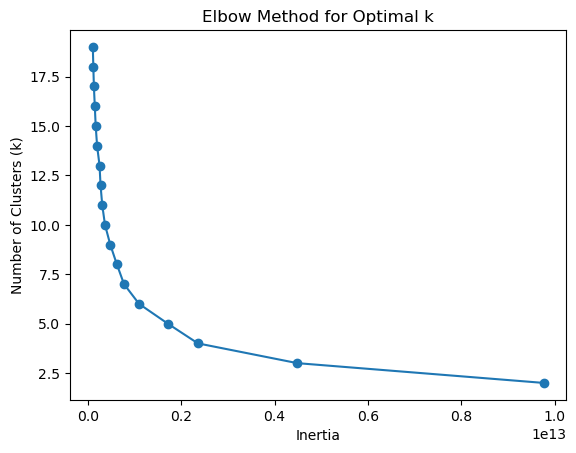

In [147]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 20)  # Test clusters from 2 to 20
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(inertia, K, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Inertia')
plt.ylabel('Number of Clusters (k)')
plt.show()

The plot above stops decreasing significantly at around 9 clusters hence choosing 9 as number of clusters

Cluster Centers:
 [[ 1.46664512e-02  7.41967411e-03  1.04072471e-03 -2.81268791e-03
   1.76108357e+04  5.93753400e-02]
 [ 9.78781081e-02 -3.87931551e-03 -4.85498589e-03 -1.54593975e-02
   7.55193373e+03  5.88388750e-02]
 [ 2.29797568e-01  1.56254842e-02  2.03916923e-02 -8.57580639e-03
   2.21152297e+04  5.95574358e-02]
 [-1.21581357e-01 -1.89055332e-02 -1.35858614e-03  1.68204264e-02
   2.63225268e+04  5.78707989e-02]
 [-1.12267548e-01 -2.67620854e-03 -3.01004064e-03  1.24358980e-02
   2.42290407e+03  5.94358048e-02]
 [-1.20724159e-01 -3.25275746e-03 -1.23036144e-02  1.88134502e-04
   1.26648689e+04  5.89323752e-02]]
         rating_number  Review_character_count  text_sentiment  \
Cluster                                                          
0             0.014995                0.007164        0.001778   
1             0.097704               -0.003637       -0.005513   
2             0.229832                0.015802        0.020290   
3            -0.121434               -0.01904

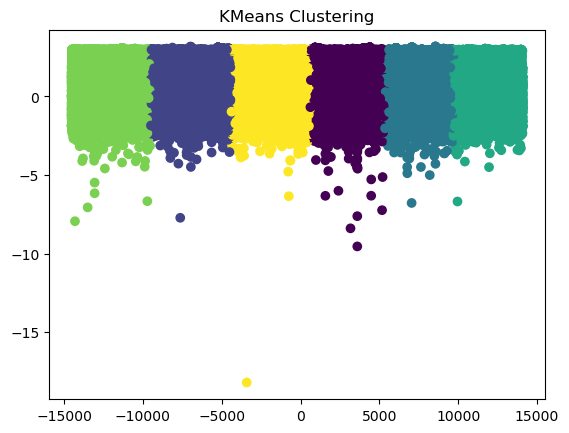

In [249]:

#Step 1 - preparing the selected data
X = Amazon_data[selected_features]
#Standardize the features - already done

from sklearn.cluster import KMeans

# Perform KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=42)  # Assuming 9 clusters (fake vs. genuine)
kmeans_labels = kmeans.fit_predict(X)

# Add cluster labels to the dataset for analysis
Amazon_data['kmeans_cluster'] = kmeans_labels

# Print cluster centers (optional)
print("Cluster Centers:\n", kmeans.cluster_centers_)

# Add cluster labels to the dataset
X_clustered = X.copy()
X_clustered['Cluster'] = kmeans.labels_

# Calculate statistics for each cluster
cluster_stats = X_clustered.groupby('Cluster').mean()
print(cluster_stats)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("KMeans Clustering")
plt.show()

Evaluating fake reviewes based on cluster size and text subjectivity

In [251]:
# Define thresholds for classification
cluster_sizes = pd.Series(kmeans.labels_).value_counts()
print(cluster_sizes)
total_reviews = cluster_sizes.sum()
size_threshold = total_reviews * 0.15 # Adjust based on data
sentiment_threshold = 0.7  # Extreme sentiment values (fake)
subjectivity_threshold = 0.9  # Threshold for high subjectivity
short_review_threshold = -0.07  # Threshold for low review_character_count

print("Size Threshold:", size_threshold)
# Identify fake clusters
fake_clusters = cluster_sizes[cluster_sizes < size_threshold].index  # Small clusters
fake_clusters = fake_clusters.union(cluster_stats[cluster_stats['text_subjectivity'] > subjectivity_threshold].index)  # High subjectivity
fake_clusters = fake_clusters.union(cluster_stats[cluster_stats['Review_character_count'] < short_review_threshold].index)  # Short reviews
fake_clusters = fake_clusters.union(cluster_stats[cluster_stats['text_sentiment'] > sentiment_threshold].index)
# Map clusters to Fake or Not Fake
cluster_labels = {cluster: 'Fake' if cluster in fake_clusters else 'Not Fake' for cluster in cluster_sizes.index}

# Assign classification to reviews
X_clustered['Review Classification'] = X_clustered['Cluster'].map(cluster_labels)
print(X_clustered['Review Classification'].value_counts())

# Add classification to the original dataset
Amazon_data['Review KMEANS Classification'] = X_clustered['Review Classification']


0    142491
4    103012
1     95984
2     90023
5     89289
3     80757
Name: count, dtype: int64
Size Threshold: 90233.4
Review Classification
Not Fake    341487
Fake        260069
Name: count, dtype: int64


In [ ]:
# #print("Cluster Centers:\n", kmeans.cluster_centers_)
# # Example mapping based on cluster size and features
# cluster_sizes = pd.Series(kmeans.labels_).value_counts()
# print(cluster_sizes)
# total_reviews = cluster_sizes.sum()
# threshold = total_reviews * 0.099  # Set threshold at 9.9% of the total points

# print(f"Threshold (1% of total points): {threshold}")

# fake_clusters = cluster_sizes[cluster_sizes < threshold].index  # Adjust threshold as needed


# # Assign labels to clusters
# cluster_labels = {cluster: 'Fake' if cluster in fake_clusters else 'Not Fake' for cluster in range(50)}

# # Map the labels to the dataset
# X_clustered['Review Classification'] = X_clustered['Cluster'].map(cluster_labels)
# print(X_clustered['Review Classification'].value_counts())
# Amazon_data['Review KMEANS Classification'] = X_clustered['Review Classification']

0    142491
4    103012
1     95984
2     90023
5     89289
3     80757
Name: count, dtype: int64
Threshold (1% of total points): 59554.044
Review Classification
Not Fake    601556
Name: count, dtype: int64


In [254]:
Amazon_data.head()

,rating,asin,parent_asin,user_id,timestamp,helpful_vote,year,month,average_rating,rating_number,...,Combined_w2v_max,Combined_w2v_sum,Description_w2v_mean,Description_w2v_max,Description_w2v_sum,kmeans_cluster,Review K mean Classification,Cluster,Review HDBSCAN Classification,Review KMEANS Classification
0,0.700819,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,-0.164483,2020,5,0.441622,-0.149590,...,2.279460,4.563182,0.068119,1.993891,3.405972,1,NaN,8913,Not Fake,Not Fake
1,0.039938,B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.069999933,0.024726,2020,5,-0.069276,-0.352464,...,2.180453,3.435599,0.000000,0.000000,0.000000,2,NaN,2428,Not Fake,Not Fake
2,0.700819,B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052000046,0.213934,2020,5,0.611921,0.045245,...,2.630500,4.074153,0.094360,2.120875,4.717975,0,NaN,2996,Not Fake,Not Fake
3,-1.942706,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220000029,-0.164483,2022,1,-5.178249,-0.386483,...,2.178425,5.106878,0.066268,2.106273,3.313422,3,NaN,116,Not Fake,Not Fake
4,0.700819,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.533999919,-0.164483,2020,12,-0.920771,-0.374731,...,2.756100,3.466857,0.000000,0.000000,0.000000,3,NaN,987,Not Fake,Not Fake


EVALUATION METRIC FOR K MEANS CLUSTERING

In [255]:
from sklearn.metrics import silhouette_score
import numpy as np

# Subsample the data
subsample_size = 50000  # Adjust based on available resources
X_subsample = X.sample(n=subsample_size, random_state=42)
kmeans_labels_subsample = kmeans.predict(X_subsample)  # Get labels for the subsample

# Compute Silhouette Score on the subsample
silhouette_avg = silhouette_score(X_subsample, kmeans_labels_subsample)
print("Silhouette Score (Subsample):", silhouette_avg)


Silhouette Score (Subsample): 0.5670971967611418


Interpret Silhouette Score Values
+1 (Near Perfect Clustering):

Clusters are well-separated and points are tightly grouped around their centroids.
All points are closer to their own cluster than any other cluster.
0 (Ambiguous Clustering):

Points are equidistant between two clusters, indicating overlap or poorly defined clusters.
May suggest:
The number of clusters (k) is not optimal.
The dataset is not naturally separable.
Negative Values (-1 to 0):

Points are assigned to the wrong cluster (closer to another cluster than their own).
Indicates poor clustering or excessive overlap between clusters.

HDBSCAN


In [75]:
pip install hdbscan

Note: you may need to restart the kernel to use updated packages.


In [256]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



import hdbscan

#For datasets where small clusters (e.g., niche patterns or anomalies) are important, use a smaller min_cluster_size.

hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=4, min_cluster_size=9)
hdbscan_labels = hdbscan_clusterer.fit_predict(X)
# min_Samples This defines the minimum number of points needed to form a "core point" around which a dense cluster is built. should be small 
# min_cluster_size This defines the minimum number of points needed to form a cluster.




In [257]:
import numpy as np
import pandas as pd

# Create a DataFrame for cluster assignments
cluster_counts = pd.Series(hdbscan_labels).value_counts()
print("Cluster Sizes:")
print(cluster_counts)

# Count the number of outliers (labeled as -1)
num_outliers = (hdbscan_labels == -1).sum()
print(f"\nNumber of noise points (outliers): {num_outliers}")


Cluster Sizes:
-1       175838
 9971      2486
 7258      1408
 3037      1357
 1550       950
          ...  
 5551         9
 8215         9
 1060         9
 4663         9
 2006         9
Name: count, Length: 10374, dtype: int64

Number of noise points (outliers): 175838


In [258]:
cluster_counts.min(), cluster_counts.max()
list(cluster_counts.items())

[(-1, 175838),
 (9971, 2486),
 (7258, 1408),
 (3037, 1357),
 (1550, 950),
 (7765, 844),
 (5258, 766),
 (1522, 651),
 (151, 633),
 (3882, 626),
 (1962, 562),
 (3468, 558),
 (5417, 550),
 (4419, 542),
 (2230, 532),
 (6376, 532),
 (6390, 529),
 (2384, 520),
 (4819, 514),
 (6873, 509),
 (7992, 480),
 (707, 473),
 (1772, 468),
 (2469, 461),
 (9272, 451),
 (4351, 449),
 (736, 441),
 (5168, 431),
 (4002, 423),
 (4761, 414),
 (2381, 405),
 (3668, 401),
 (8980, 398),
 (6938, 392),
 (219, 391),
 (6664, 387),
 (8837, 385),
 (2818, 380),
 (4935, 380),
 (3979, 380),
 (4201, 375),
 (8272, 360),
 (1827, 357),
 (1375, 356),
 (4999, 355),
 (8066, 346),
 (6058, 345),
 (4782, 344),
 (7244, 342),
 (9129, 342),
 (4929, 341),
 (7095, 340),
 (159, 340),
 (1502, 336),
 (915, 335),
 (3863, 332),
 (2297, 330),
 (7370, 327),
 (3902, 326),
 (5065, 320),
 (5201, 317),
 (4885, 316),
 (1762, 314),
 (1045, 312),
 (247, 311),
 (1022, 309),
 (4666, 309),
 (5022, 306),
 (1779, 306),
 (8498, 305),
 (5520, 304),
 (5280, 3

In [259]:
threshold = 20
print(threshold)

# Create a DataFrame to map the clusters to fake or not fake
cluster_labels = {label: 'Not Fake' if (count>=threshold and label!=-1) else 'Fake' for label, count in cluster_counts.items()}
cluster_labels[-1] = 'Fake'  # Label noise points as 'Fake'

# Now classify each data point based on its cluster label
review_classification = pd.Series(hdbscan_labels).map(cluster_labels)
print("\nReview Classification (Fake/Not Fake):")
print(review_classification.value_counts())

# Optionally, you can now add the classification to your original data (X_clustered is your data with cluster labels)
X_clustered = Amazon_data  # Assuming your data is in 'X'
X_clustered['Cluster'] = hdbscan_labels
X_clustered['Review HDBSCAN Classification'] = review_classification
Amazon_data.head()

20

Review Classification (Fake/Not Fake):
Not Fake    368195
Fake        233361
Name: count, dtype: int64


,rating,asin,parent_asin,user_id,timestamp,helpful_vote,year,month,average_rating,rating_number,...,Combined_w2v_max,Combined_w2v_sum,Description_w2v_mean,Description_w2v_max,Description_w2v_sum,kmeans_cluster,Review K mean Classification,Cluster,Review HDBSCAN Classification,Review KMEANS Classification
0,0.700819,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923000097,-0.164483,2020,5,0.441622,-0.149590,...,2.279460,4.563182,0.068119,1.993891,3.405972,1,NaN,8115,Not Fake,Not Fake
1,0.039938,B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.069999933,0.024726,2020,5,-0.069276,-0.352464,...,2.180453,3.435599,0.000000,0.000000,0.000000,2,NaN,2220,Not Fake,Not Fake
2,0.700819,B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052000046,0.213934,2020,5,0.611921,0.045245,...,2.630500,4.074153,0.094360,2.120875,4.717975,0,NaN,2748,Not Fake,Not Fake
3,-1.942706,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220000029,-0.164483,2022,1,-5.178249,-0.386483,...,2.178425,5.106878,0.066268,2.106273,3.313422,3,NaN,112,Not Fake,Not Fake
4,0.700819,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.533999919,-0.164483,2020,12,-0.920771,-0.374731,...,2.756100,3.466857,0.000000,0.000000,0.000000,3,NaN,918,Not Fake,Not Fake


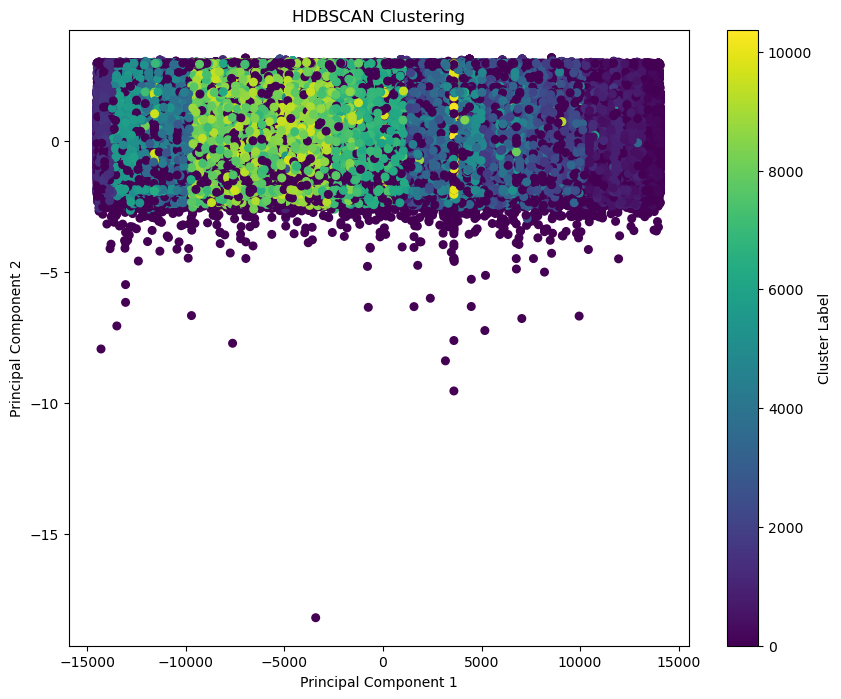

In [260]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hdbscan_labels, cmap='viridis', marker='o', s=30)
plt.title("HDBSCAN Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()


In [261]:
# Check cluster stability
print("Cluster Stability Scores:", sum(hdbscan_clusterer.probabilities_)/len(hdbscan_clusterer.probabilities_))


Cluster Stability Scores: 0.6013840489787551


HDBSCAN has built-in evaluation tools that are computationally efficient and tailored for its hierarchical, density-based approach:

a. Cluster Stability
HDBSCAN assigns a stability score to each cluster, indicating how well-defined the cluster is.
Clusters with higher stability scores are more reliable and meaningful